# Clifford Quantum Cellular Automata
A Clifford Quantum Cellular Automaton (CQCA) is a *globally unique* ruleset for mapping Pauli gates to a set of Pauli gates (or identity gates).
This ruleset is applied, at each time step, to every cell of an infinite lattice of cells.
Each cell holds a Pauli gate.

The application of a gate to another follows following rules:
- $i \times i = I, i \in \{I, X, Y, Z\}$ (Unitary operator)
- $i \times I = I \times i = i, i \in \{I, X, Y, Z\}$ (Identity is neutral)
- $i \times j = k, i \neq j \neq k \in \{X, Y, Z\}$

Initially, all cells of the lattice are identity gates.
However, one can change some of the cells before the first iteration to form a starting configuration.
By then iterating over time steps, the configuration of the lattice changes.
The patterns in the change are discussed in this notebook.

In this notebook, the lattice is always 1-dimensional (i.e., a spin chain).

**Disclaimer:**
This notebook heavily relies on the paper [TODO citation].
However, notations, results and interpretations might differ.

## Environment Preparation
Technical necessities for the notebook to work properly.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from model.automaton import Automaton
from model.lattice import Lattice, plot_evolution, plot_entanglement
from model.gate import Identity, PauliX, PauliY, PauliZ

In [3]:
debug = False

## Rulesets
Rules are specified by mapping gates to a list of gates.
For each cell, the corresponding rule is applied to the cell itself, as well as its neighborhood.

Mapping from an X gate:

First, a binary vector specifies the cells, which map to X gates. The vector also has a set origin cell:

$
\xi_{X \rightarrow X} = (\cdots 0 1 0 \underline{1} 0 1 0 \cdots)
$

The next binary vector shows the mapping to Z gates:

$
\xi_{X \rightarrow Z} = (\cdots 0 1 1 0 \underline{1} 0 1 1 0\cdots)
$

Mapping from a Z gate:

The same way there are two binary vectors mapping Z to X and Z to Z gates.
In total, this yields the following matrix:

$
\begin{pmatrix}
\xi_{X \rightarrow X} & \xi_{X \rightarrow X} \\
\xi_{Z \rightarrow X} & \xi_{Z \rightarrow Z}
\end{pmatrix}
$

The mapping from a Y gate results from applying both an X and a Z gate (it also introduces a $1i$ coeffiecient, but it is of no importance here).

Furthermore, the binary vectors can be represented with just the indices relative to the origin, i.e., the cell that the mapping comes from.

The ruleset

$
X \rightarrow Z \\
Z \rightarrow Z X Z
$

and therefore

$
Y \rightarrow Z Y Z
$

are thus represented by the following matrix:

$
\begin{pmatrix}
() & (0) \\
(0) & (-1, 1)
\end{pmatrix}
$

This matrix specifies the so called glider CQCA, the behavior of which is studied next.

## Classes of CQCAs

There are multiple classes of CQCAs:
- Glider CQCAs
- Fractal CQCAs
- Periodic CQCAs

### Glider CQCA

In [4]:
glider = Automaton([[[], [0]], [[0], [-1, 1]]])

#### Evolution of a Pauli Z Gate
A cell containing a Z gate will contain an X gate in the next time step, and also apply a Z gate to the surrounding cells.

In [5]:
plot_evolution(glider, [PauliZ()], 5)

          Z          
        Z X Z        
      Z X Z X Z      
    Z X Z X Z X Z    
  Z X Z X Z X Z X Z  
Z X Z X Z X Z X Z X Z


#### Evolution of a Pauli X Gate.
An X gate will become a Z gate.
The neighborhood is unchanged.
From the second timestep forward the lattice behaves as if it had started with a Z gate.

In [6]:
plot_evolution(glider, [PauliX()], 5)

        X        
        Z        
      Z X Z      
    Z X Z X Z    
  Z X Z X Z X Z  
Z X Z X Z X Z X Z


Since quantum gates, especially Pauli gates, are unitary, they are able to cancel each other out into identity gates.
With the right configuration, the "active" gates (i.e., those, which are not the identity gates) propagate to a certain direction, leaving behind only "inactive" identity gates.

Starting with Pauli X and Z gates next to each other, the glider CQCA moves the two gates one cell to the right with each time step.

In [7]:
plot_evolution(glider, [PauliX(), PauliZ()], 5)

X Z          
  X Z        
    X Z      
      X Z    
        X Z  
          X Z


Analogously, it can also move to the left with a mirrored initial configuration.

In [8]:
plot_evolution(glider, [PauliZ(), PauliX()], 5)

          Z X
        Z X  
      Z X    
    Z X      
  Z X        
Z X          


### Fractal CQCA

The following configuration demonstartes fractal behavior.

In [9]:
fractal = Automaton([[[-1, 0, 1], [0]], [[0], []]])

In [10]:
plot_evolution(fractal, [PauliX()], 25)

                                                  X                                                  
                                                X Y X                                                
                                              X Z Z Z X                                              
                                            X Y   X   Y X                                            
                                          X Z Y   Y   Y Z X                                          
                                        X Y X Z   Z   Z X Y X                                        
                                      X Z Z Z     X     Z Z Z X                                      
                                    X Y   X X   X Y X   X X   Y X                                    
                                  X Z Y   Z Z   Z Z Z   Z Z   Y Z X                                  
                                X Y X Z X X X   X X X   X X X Z X Y X             

With enough iterations (more than are feasible with the current visualization code) this CQCA evolves similar to this [Citation TODO]:

![Fractal CQCA](images/fractal.png)

### Periodic CQCA

Lastly, there are periodic CQCAs.
This means that after a certain step, the configuration returns to itself after a finite amount of time steps.

In [11]:
periodic = Automaton([[[0], []], [[-1, 1], [0]]])

In [12]:
plot_evolution(periodic, [PauliX()], 5)

  X  
Z X Z
  X  
Z X Z
  X  
Z X Z


## Translation invariant stabilizer state

TODO

## Entanglement
When the initial cells are entangled, their "reach", which may be increasing over time, entangles further cells.
Entanglement can also be destroyed, if a cell returns to an identity gate.

In [14]:
alms = [
    (glider, "Glider", "v"),
    (fractal, "Fractal", "x"),
    (periodic, "Periodic", "s")
]
init_config = [PauliY(), PauliX(), PauliY()]

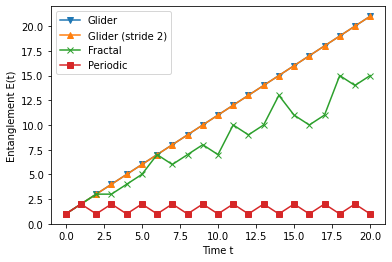

In [15]:
plot_entanglement(alms, init_config, 20)